# Graph Embedding

This notebook creates a graph with nodes labeled by the lexicon terms and
topic-embeddings of the respective documents as node features.
We then predict existence of the edges based on the similarity of node features. We use
KL-divergence of the distributions of the node features as edge weights.

Here is the steps we will take:

- load the GPT-3 topic-embeddings of the PubMed documents.
- Calculate the adjacency matrix using KL-divergence of the node pairs.
<!-- - Create a list of random walks that goes from constructs to the tasks only. -->
<!-- - Find an embedding for the graph using the metapath2vec model. -->
<!-- - Predict links  -->

In [56]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix
from sklearn.preprocessing import normalize

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [57]:
# load weights, clusters and metadata (takes ~ 20sec)

clusters = pd.read_csv('models/gpt3/abstracts_gpt3ada_clusters.csv.gz', index_col=0)
weights = np.load('models/gpt3/abstracts_gpt3ada_weights.npz')['arr_0']
clusters['weights'] = list(weights)

# load abstracts
pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

print(f'Successfully create a list of {len(pubmed)} abstract embeddings.')

Successfully create a list of 293014 abstract embeddings.


## Node-node similarity

Here, we calculate the similarity between nodes using the node features. We use
KL-divergence of the node features a measure of distance between the two.

In [219]:
def find_category_by_label(label, pubmed=pubmed):
  return pubmed.query('label == @label')['category'].iloc[0]


def nll(X, dist):
  return - tf.reduce_mean(dist.log_prob(X))


@tf.function
def get_loss_and_grads(X_train, dist):
  with tf.GradientTape() as tape:
    tape.watch(dist.trainable_variables)
    loss = nll(X_train, dist)
  grads = tape.gradient(loss, dist.trainable_variables)
  return loss, grads

def fit_multivariate_normal(data, n_epochs=10):
  
  dist = tfd.MultivariateNormalDiag(
    loc=tf.Variable(data.mean(axis=0), name='loc'),
    scale_diag=tf.Variable(np.ones(data.shape[1]), name='scale'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

  for _ in range(n_epochs):
    X = data
    loss, grads = get_loss_and_grads(X, dist)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    loc_value = dist.loc.value()
  return dist

tqdm.pandas()

node_distributions = pubmed.groupby('label')['weights'].progress_apply(
  lambda docs: fit_multivariate_normal(np.stack(docs))
)

node_distributions
# n2n_sim.index = n2n_sim.index.droplevel(level=1)
# n2n_sim.columns = n2n_sim.columns.droplevel(level=1)

100%|██████████| 170/170 [01:24<00:00,  2.00it/s]


label
AnalogyMakingTask                  tfp.distributions.MultivariateNormalDiag("Mult...
AntiSaccadeTask                    tfp.distributions.MultivariateNormalDiag("Mult...
Attention                          tfp.distributions.MultivariateNormalDiag("Mult...
AttentionNetworkTest               tfp.distributions.MultivariateNormalDiag("Mult...
AttentionalControl                 tfp.distributions.MultivariateNormalDiag("Mult...
                                                         ...                        
VisuospatialSketchpad              tfp.distributions.MultivariateNormalDiag("Mult...
VisuospatialWorkingMemory          tfp.distributions.MultivariateNormalDiag("Mult...
Volition                           tfp.distributions.MultivariateNormalDiag("Mult...
WCST_-_Wisconsin_Card_Sort_Test    tfp.distributions.MultivariateNormalDiag("Mult...
WorkingMemory                      tfp.distributions.MultivariateNormalDiag("Mult...
Name: weights, Length: 170, dtype: object

In [231]:
def kl_dist(p,q):
  return 
# n2n_sim = node_distributions.to_frame().corr(method=kl_dist)
# n2n_sim

n2n_kl = np.zeros((len(node_distributions), len(node_distributions)))

for i,lbl_i in tqdm(enumerate(node_distributions.index)):
  for j, lbl_j in enumerate(node_distributions.index):
    kl = node_distributions.loc[lbl_i].kl_divergence(node_distributions.loc[lbl_j]).numpy()
    n2n_kl[i,j] = kl

n2n_kl = pd.DataFrame(n2n_kl, index=node_distributions.index, columns=node_distributions.index)
n2n_kl

170it [02:37,  1.08it/s]


label,AnalogyMakingTask,AntiSaccadeTask,Attention,AttentionNetworkTest,AttentionalControl,AttentionalInertia,AuditoryAttentionTask,AutomatedOperationSpanTask,BART,BackwardSpanTask,...,Updating,VerbalProcessing,VerbalWorkingMemory,Verbal_fluency_task,VisuospatialProcessing,VisuospatialSketchpad,VisuospatialWorkingMemory,Volition,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory
label,,,,,,,,,,,,,,,,,,,,,
AnalogyMakingTask,0.000000,0.480791,0.455000,0.372193,0.307998,0.502274,0.475014,0.526733,0.416358,0.436427,...,0.472331,0.448609,0.376314,0.381776,0.437853,0.494940,0.481683,0.444415,0.364877,0.370662
AntiSaccadeTask,0.480834,0.000000,0.430586,0.426067,0.319335,0.470805,0.518196,0.544337,0.427576,0.406780,...,0.525452,0.449250,0.372095,0.332178,0.374173,0.461986,0.487436,0.372541,0.354757,0.356687
Attention,0.455016,0.430558,0.000000,0.370677,0.278954,0.479944,0.435639,0.476713,0.407598,0.395215,...,0.479647,0.428974,0.364673,0.320013,0.379970,0.435834,0.425671,0.371290,0.338546,0.295152
AttentionNetworkTest,0.372204,0.426031,0.370670,0.000000,0.271142,0.462819,0.418371,0.461736,0.379026,0.341868,...,0.438211,0.370970,0.314299,0.303247,0.368899,0.395527,0.415942,0.351564,0.324143,0.309843
AttentionalControl,0.308006,0.319313,0.278952,0.271140,0.000000,0.398385,0.378144,0.426743,0.292790,0.282274,...,0.376553,0.301287,0.243033,0.227409,0.279674,0.370861,0.339707,0.266205,0.222839,0.231461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VisuospatialSketchpad,0.494990,0.462010,0.435901,0.395559,0.370932,0.507420,0.516293,0.576868,0.471186,0.465604,...,0.544442,0.450528,0.393291,0.339301,0.415177,0.000000,0.483517,0.430706,0.369380,0.386620
VisuospatialWorkingMemory,0.481761,0.487465,0.425701,0.415979,0.339744,0.517858,0.524733,0.568375,0.451997,0.425849,...,0.540998,0.483093,0.373334,0.364458,0.420296,0.483501,0.000000,0.424177,0.348423,0.372048
Volition,0.444433,0.372526,0.371297,0.351568,0.266208,0.499662,0.403722,0.489492,0.379910,0.372312,...,0.478950,0.411621,0.330449,0.304361,0.360763,0.430641,0.424124,0.000000,0.277097,0.308407


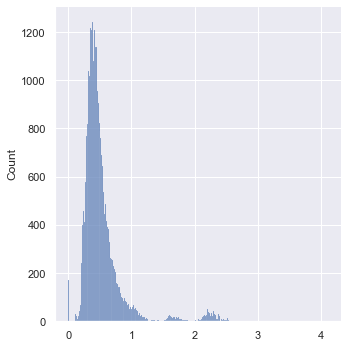

In [245]:
sns.displot(n2n_kl.values.flatten())

In [198]:
# plot similarity matrix of all the node pairs

# max-pooling
# node_features = (
#   pubmed.groupby('label')['weights'].apply(lambda x: np.max(np.stack(x.values), axis=0))
# )

node_features = pubmed.groupby('label')['weights'].mean()

node_features = pd.DataFrame(np.stack(node_features), index=node_features.index)

node_features.iloc[:,:] = normalize(node_features.values, norm='l1')

# add node types (task or construct)
# node_features['category'] = node_features.index.to_series().apply(find_category_by_label)
# node_features.set_index(['category'], append=True, inplace=True)

# predict links by cosine similarity of topic-embeddings of the node pairs
n2n_sim = get_similarity_matrix(node_features, metric='cosine', pivot_by_category=False)
np.fill_diagonal(n2n_sim.values, 0.)


In [201]:
# visualize the similarity between constructs pairs regardless of the underlying tasks

# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
plot_data = n2n_sim.drop(index=tasks, columns=tasks)

# # heatmap plot categorized by label category, either task or construct
# g = sns.clustermap(labels_sim,
#                    figsize=(25, 25),
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    robust=True)
# plt.show()

dashbio.Clustergram(
  data=plot_data,
  column_labels=plot_data.columns.to_list(),
  row_labels=plot_data.index.to_list(),
  cluster='all',
  center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)


## Popular Constructs

In [202]:
# plot only popular tasks and popular constructs

n_popular_labels = 40

popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

popular_label_embeddings = n2n_sim.query('label in @popular_labels')

popular_labels_sim = get_similarity_matrix(
  popular_label_embeddings,
  metric='cosine',
  pivot_by_category=False)

# # drop tasks for visualization
tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
popular_labels_sim.drop(index=tasks, columns=tasks, errors='ignore', inplace=True)

# g = sns.clustermap(popular_labels_sim, robust=True,
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    cmap='viridis_r',
#                   )
# plt.show()

import dash_bio as dashbio

dashbio.Clustergram(
  data=popular_labels_sim,
  column_labels=popular_labels_sim.columns.to_list(),
  row_labels=popular_labels_sim.index.to_list(),
  center_values=False,
  cluster='all',
  height=800,
  width=900,
  display_ratio=[0.001, 0.001], 
  color_map='RdBu_r',
  # hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

In [203]:
# plot kl-divergence between construct labels, ignoring the task labels.

X = popular_label_embeddings.query('category.str.contains("Construct")')
X_sim = get_similarity_matrix(X, metric='cosine', pivot_by_category=False)

sns.set('poster')
g = sns.clustermap(X_sim,figsize=(22,20), dendrogram_ratio=0.0001,
               cbar_pos=(1.0, 0.73, 0.03, 0.25),
               cmap='RdBu_r', cbar_kws={'label': 'cosine similarity'})
g.ax_heatmap.set(xlabel='Construct', ylabel='Construct')
plt.suptitle('Cosine similarity between most popular constructs',y=1.01)
plt.show()

UndefinedVariableError: name 'category' is not defined

In [19]:
# create a graph

import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk

embeddings = popular_label_embeddings

sim = get_similarity_matrix(embeddings, metric='kl', pivot_by_category=False)
sim.columns.name = 'source'
sim.index.name = 'target'

# keep = np.triu(np.ones(sim.shape)).astype('bool').reshape(sim.size)
adj = sim.stack().to_frame().reset_index().rename(columns={0: 'weight'})

adj = adj.query('target != source')

# use separate filtering for each of the edge types
edge_threshold = adj['weight'].median() + adj['weight'].std()

edges = adj.query('weight >= @edge_threshold')

constructs = label_embeddings.query('category == "CognitiveConstruct"').reset_index(1,drop=True)
tasks = label_embeddings.query('category == "CognitiveTask"').reset_index(1,drop=True)

G = sg.StellarGraph(
  nodes = {'task': tasks,
           'construct': constructs},
  edges=edges)
print(G.info())

2022-01-21 18:10:31.940359: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


StellarGraph: Undirected multigraph
 Nodes: 170, Edges: 1098

 Node types:
  task: [98]
    Features: float32 vector, length 509
    Edge types: task-default->construct, task-default->task
  construct: [72]
    Features: float32 vector, length 509
    Edge types: construct-default->construct, construct-default->task

 Edge types:
    construct-default->task: [542]
        Weights: range=[1.42376, 3.64397], mean=1.85238, std=0.505267
        Features: none
    task-default->task: [480]
        Weights: range=[1.42983, 3.69662], mean=1.97829, std=0.539378
        Features: none
    construct-default->construct: [76]
        Weights: range=[1.4276, 1.78699], mean=1.53227, std=0.0938251
        Features: none


In [9]:
# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
print(f'[MetaPath2Vec] Created {len(walks)} random walks.')
# DEBUG: print('Random walks starting from the "RewardProcessing" node:',
# DEBUG:      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

print('[MetaPath2Vec] Now training the Word2Vec model...', sep=' ')
model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)
model.save('models/gpt3/abstracts_metapath2vec.pkl')

print('[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.')

[MetaPath2Vec] Created 1700 random walks.
[MetaPath2Vec] Now training the Word2Vec model...
[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.


In [13]:
# query the joint graph


#  visual-spatial and organizational processing abilities, as well as nonverbal problem-solving skills. 
 
# FIXME: there is a typo in "CogntiveControl"; it comes from a type in the original lexicon.
model.wv.most_similar(
  positive=['BART'],
  # negative=['TMT_-_Trail_Making_Task']
  topn=10)

# TODO filter by category


[('NonverbalWorkingMemory', 0.22190137207508087),
 ('Incompatibility_test', 0.20269256830215454),
 ('Hayling_test', 0.1891143023967743),
 ('DegradedVigilanceTask', 0.17823150753974915),
 ('OddOneOutTask', 0.13242526352405548),
 ('Binding', 0.12700197100639343),
 ('FeedbackLearning', 0.12263721227645874),
 ('Attention', 0.11427738517522812),
 ('ContiniousPerformanceTask', 0.11308609694242477),
 ('CognitiveInhibition', 0.11181913316249847)]

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


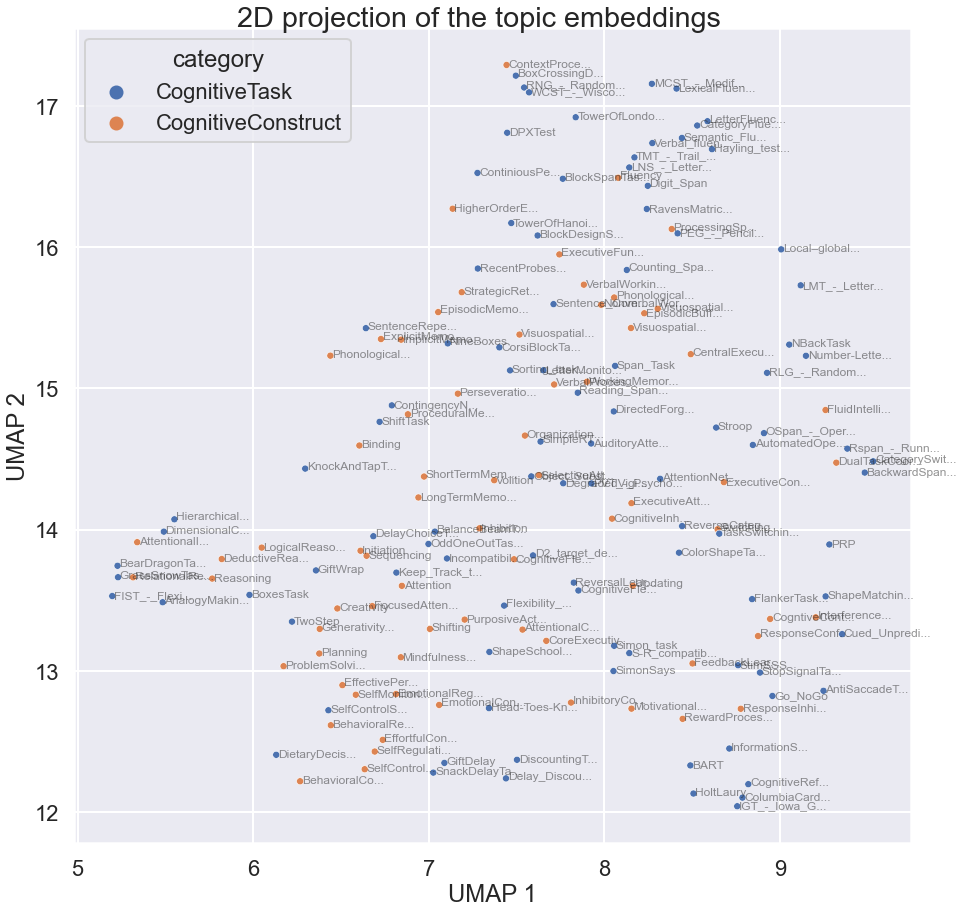

In [14]:
# Plot all tasks and constructs in a lower dimensional 3d space

import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(popular_label_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(label_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=popular_label_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=label_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [15]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext

Last updated: 2022-01-21T16:09:50.086463+01:00

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
scikit-learn  : 0.0
python.cogtext: 0.1.2022012116

plotly      : 5.3.1
seaborn     : 0.11.2
pandas      : 1.3.4
dash_bio    : 0.8.0
numpy       : 1.20.3
sys         : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:38:53) 
[Clang 11.1.0 ]
matplotlib  : 3.4.3
stellargraph: 1.2.1

